In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import os
from going_modular.model.ConcatMTLFaceRecognition import ConcatMTLFaceRecognitionV3, MTLFaceRecognition
from torch.utils.data import Dataset, DataLoader
import csv
import json
import cv2
import numpy as np
import albumentations as A
import random
import shutil
import pandas as pd
import ast
import matplotlib.pyplot as plt
from typing import Tuple
from pathlib import Path

random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Đặt seed toàn cục
seed = 42
torch.manual_seed(seed)

CONFIGURATION = {
    'type': 'albedo',
    
    # Thư mục
    'dataset_dir': './Dataset',
    'checkpoint': './checkpoint/concat3/models/checkpoint.pth',
    'num_classes': 262,
    
    # Cấu hình train
    'device': device,
    'backbone': 'miresnet18',
    'image_size': 256,
    'batch_size': 64,
    'num_workers': 4
}

test_transform = A.Compose([
    A.Resize(height=CONFIGURATION['image_size'], width=CONFIGURATION['image_size'])
], additional_targets={
    'albedo': 'image',
    'depthmap': 'image'
})

# Tạo gallery

Lấy 1 ảnh mỗi id đưa vào file gallery.csv, sau đó đưa toàn bộ ảnh trong gallery_remaining.csv vào matching với gallery để ra accuracy

In [2]:
# Đọc file CSV ban đầu
gallery_df = pd.read_csv("./Dataset/gallery_set.csv")

# Lấy một dòng ngẫu nhiên cho mỗi id
gallery_sample = gallery_df.groupby('id').apply(lambda x: x.sample(1)).reset_index(drop=True)

# Lưu kết quả (1 dòng mỗi id) vào file CSV
gallery_sample.to_csv("test_models/gallery.csv", index=False)

# Lấy những dòng còn lại của cùng một id và lưu vào file khác
gallery_remaining = gallery_df[~gallery_df.index.isin(gallery_sample.index)]

# Lưu những dòng còn lại vào file CSV khác
gallery_remaining.to_csv("test_models/gallery_remaining.csv", index=False)

In [5]:
class ConcatGalleryExrDatasetV3(Dataset):
    
    def __init__(self, dataset_dir:str, transform, metadata_path):
        self.metadata_path = metadata_path
        self.albedo_dir = Path(dataset_dir) / 'Albedo' / 'gallery'
        self.depth_dir = Path(dataset_dir) / 'Depth_Map' / 'gallery'
        self.normal_dir = Path(dataset_dir) / 'Normal_Map' / 'gallery'
        
        self.transform = transform
        self.classes = sorted(os.listdir(self.albedo_dir))
        
        metadata = pd.read_csv(metadata_path)

        # Tạo danh sách các đường dẫn và id tương ứng
        self.data = [
            (
                (
                    Path(self.normal_dir, str(row['id']), f"{row['session']}.exr"),  # Đường dẫn albedo
                    Path(self.albedo_dir, str(row['id']), f"{row['session']}.exr"),  # Đường dẫn normal
                    Path(self.depth_dir, str(row['id']), f"{row['session']}.exr")   # Đường dẫn depth
                ),
                row['id']
            )
            for _, row in metadata.iterrows()
        ]
        
        self.transform = transform

                
    def __len__(self):
        return len(self.data)
    
    
    # Nhận vào index mà dataloader muốn lấy
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        (normal_path, albedo_path, depth_path), id = self.data[index]
        numpy_normal = self.__load_numpy_image(normal_path)
        numpy_albedo = self.__load_numpy_image(albedo_path)
        numpy_depth = self.__load_numpy_image(depth_path)
        gender, spectacles, facial_hair, pose, emotion = self.__extract_csv(albedo_path)
        
        if self.transform:
            transformed = self.transform(image=numpy_normal, albedo=numpy_albedo, depthmap=numpy_depth)
            numpy_normal = transformed['image']
            numpy_albedo = transformed['albedo']
            numpy_depth = transformed['depthmap']
        
        # Stack các tensor lại thành một tensor duy nhất
        X = torch.stack((
            torch.from_numpy(numpy_normal).permute(2, 0, 1),
            torch.from_numpy(numpy_albedo).permute(2, 0, 1), 
            torch.from_numpy(numpy_depth).permute(2, 0, 1)
        ), dim=0)
        y = torch.tensor([int(id), gender, spectacles, facial_hair, pose, emotion], dtype=torch.int)
        return X, y
        
        
    def __load_numpy_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        if image is None:
            raise ValueError(f"Failed to load image at {image_path}")
        elif len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        return image


    def __extract_csv(self, image_path):
        id = image_path.parent.name
        session = image_path.stem
        df = pd.read_csv(self.metadata_path)
        
        # Lọc dữ liệu theo ID và session
        filtered_data = df[(df['id'] == int(id)) & (df['session'] == session)]
        
        # Kiểm tra nếu không có hoặc có nhiều hơn 1 dòng được trả về
        if filtered_data.shape[0] != 1:
            raise Exception(f"Tìm thấy {filtered_data.shape[0]} row có {id} và {session} trong file {self.metadata_path}")
        
        row = filtered_data.iloc[0]  # Lấy dòng đầu tiên (vì chỉ có 1 dòng được trả về)
        
        return row["Gender"], row["Spectacles"], row["Facial_Hair"], row["Pose"], row["Emotion"]
    
dataset = ConcatGalleryExrDatasetV3(CONFIGURATION['dataset_dir'], test_transform, './test_models/gallery.csv')

dataloader = DataLoader(
    dataset,
    batch_size=CONFIGURATION['batch_size'],
    shuffle=True,
    num_workers=CONFIGURATION['num_workers'],
    pin_memory=True,
)

In [6]:
mtl_normalmap = MTLFaceRecognition(CONFIGURATION['backbone'], CONFIGURATION['num_classes'])
mtl_albedo = MTLFaceRecognition(CONFIGURATION['backbone'], CONFIGURATION['num_classes'])
mtl_depthmap = MTLFaceRecognition(CONFIGURATION['backbone'], CONFIGURATION['num_classes'])

model = ConcatMTLFaceRecognitionV3(mtl_normalmap=mtl_normalmap, mtl_albedo=mtl_albedo, mtl_depthmap=mtl_depthmap, num_classes= CONFIGURATION['num_classes']).to(device)
checkpoint = torch.load(CONFIGURATION['checkpoint'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

ConcatMTLFaceRecognitionV3(
  (mtl_normalmap): MTLFaceRecognition(
    (backbone): MIResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (prelu): PReLU(num_parameters=1)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (downsample): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [16]:
# Đảm bảo model đã ở chế độ evaluation
model.eval()

# Lưu tất cả embedding vào file CSV khác
gallery_db = "test_models/multi/gallery_db.csv"
print(f"Lưu dữ liệu vào {gallery_db}...")

# Mở tệp và ghi dữ liệu vào
with open(gallery_db, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'embedding'])

    # Bắt đầu không tính gradient cho embedding
    with torch.no_grad():
        for X, y in dataloader:
            # Đưa batch lên GPU nếu có
            X = X.to(device)
            y = y.to(device)
            
            # Sinh embedding từ model
            x_ids, x_genders, x_poses, x_emotions, x_facial_hairs, x_spectacles = model.get_result(X)

            # Lấy nhãn từ dữ liệu
            ids, genders, spectacles, facial_hairs, poses, emotions = y[:,0], y[:, 1], y[:, 2], y[:,3], y[:,4], y[:,5]

            # Lưu embedding vào CSV
            for x_id, id in zip(x_ids, ids):
                # Chuyển embedding thành danh sách và sau đó thành chuỗi JSON
                x_id_str = json.dumps(x_id.cpu().tolist())  # Chuyển tensor sang list Python trước khi ghi
                writer.writerow([id.item(), x_id_str])  # Chuyển id thành kiểu Python cơ bản nếu cần

print(f"Lưu thành công dữ liệu vào {gallery_db}.")

Lưu dữ liệu vào test_models/multi/gallery_db.csv...
Lưu thành công dữ liệu vào test_models/multi/gallery_db.csv.


# Matching

## Chuẩn bị

In [7]:
# Tính khoảng cách Cosine
def calculate_cosine_distances_torch(query_embedding, embeddings):
    # Chuẩn hóa vector để tính cosine similarity
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)
    embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)
    
    # Tính cosine similarity
    cosine_similarities = torch.mm(query_embedding, embeddings.T)
    # Chuyển thành khoảng cách
    return cosine_similarities

# Tính khoảng cách Euclidean
def calculate_euclidean_distances_torch(query_embedding, embeddings):
    # Tính Euclidean Distance
    euclidean_distances = torch.cdist(query_embedding, embeddings, p=2)
    return euclidean_distances

# Tìm top-k embedding gần nhất
def find_top_k_neighbors_torch(query_embedding, embeddings, labels, device, k=5, distance_metric='cosine'):
    query_embedding = torch.tensor(query_embedding, device=device, dtype=torch.float32).unsqueeze(0)
    embeddings = torch.tensor(embeddings, device=device, dtype=torch.float32)
    labels = torch.tensor(labels, device=device)

    if distance_metric == 'cosine':
        distances = calculate_cosine_distances_torch(query_embedding, embeddings).squeeze(0)
        # Lấy top-k (torch.topk trả giá trị nhỏ nhất nếu `largest=False`)
        top_k_distances, top_k_indices = torch.topk(distances, k, largest=True)
    elif distance_metric == 'euclidean':
        distances = calculate_euclidean_distances_torch(query_embedding, embeddings).squeeze(0)
        # Lấy top-k (torch.topk trả giá trị nhỏ nhất nếu `largest=False`)
        top_k_distances, top_k_indices = torch.topk(distances, k, largest=False)
    else:
        raise ValueError("Unsupported distance metric. Choose 'cosine' or 'euclidean'.")
    

    # Lấy nhãn của top-k
    top_k_labels = labels[top_k_indices]
    return top_k_distances.cpu().numpy(), top_k_labels.cpu().numpy()

df = pd.read_csv('./test_models/multi/gallery_db.csv')

# Chuyển chuỗi trong cột `Embedding` thành danh sách Python
df['embedding'] = df['embedding'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Chuyển các danh sách trong cột `Embedding` thành mảng numpy
embeddings = np.array(df['embedding'].tolist(), dtype=np.float32)

# Giữ nguyên nhãn
labels = df['id'].values

In [8]:
def calculate_top_k_accuracy(query_embedding, embeddings, labels, query_label, device, k=5, distance_metric='cosine'):
    query_label = query_label.to(device)
    query_id = query_label[0].item()
    # Tính top-k nhãn gần nhất
    _, top_k_labels = find_top_k_neighbors_torch(query_embedding, embeddings, labels, device, k, distance_metric)
    
    top_k_labels = torch.tensor(top_k_labels, device=device)
    # Kiểm tra nếu nhãn thực tế nằm trong top-k
    if torch.isin(query_id, top_k_labels).any():  # Kiểm tra nếu query_label có nằm trong top_k_labels
        return 1  # Đúng
    return 0  # Sai

def calculate_recognition_accuracy(model, dataloader, gallery_embeddings, gallery_labels, device, top_k=5, distance_metric='cosine'):
    correct_predictions_top_k = 0
    total_predictions = 0

    model.eval()  # Đảm bảo mô hình ở trạng thái eval

    with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ
        for query_images, query_labels in dataloader:
            query_images = query_images.to(device)
            query_labels = query_labels.to(device)

            # Lấy embedding từ mô hình
            query_embeddings, _, _, _, _, _ = model.get_result(query_images)
            
            # Tính accuracy cho từng query trong batch
            for idx, query_label in enumerate(query_labels):
                query_embedding = query_embeddings[idx]  # Lấy embedding của ảnh tại index idx trong batch
                
                # Tính top-k accuracy
                correct_predictions_top_k += calculate_top_k_accuracy(query_embedding, gallery_embeddings, gallery_labels, query_label, device, k=top_k, distance_metric=distance_metric)
                total_predictions += 1

    return correct_predictions_top_k / total_predictions

In [9]:
recognition_multi_dataset = ConcatGalleryExrDatasetV3(CONFIGURATION['dataset_dir'], test_transform, './test_models/gallery_remaining.csv')

recognition_dataloader = DataLoader(
    recognition_multi_dataset,
    batch_size=CONFIGURATION['batch_size'],
    shuffle=True,
    num_workers=CONFIGURATION['num_workers'],
    pin_memory=True,
)

## Multitask

In [10]:
# Tính top-1 accuracy
accuracy_top_1 = calculate_recognition_accuracy(
    model=model,
    dataloader=recognition_dataloader,
    gallery_embeddings=embeddings,
    gallery_labels=labels,
    device=device,
    top_k=1,  # Top-1 accuracy
    distance_metric='cosine'
)

# Tính top-5 accuracy
accuracy_top_5 = calculate_recognition_accuracy(
    model=model,
    dataloader=recognition_dataloader,
    gallery_embeddings=embeddings,
    gallery_labels=labels,
    device=device,
    top_k=5,  # Top-5 accuracy
    distance_metric='cosine'
)

print(f"Top-1 Accuracy: {accuracy_top_1:.2%}")
print(f"Top-5 Accuracy: {accuracy_top_5:.2%}")

Top-1 Accuracy: 99.59%
Top-5 Accuracy: 100.00%


In [11]:
# Tính top-1 accuracy
accuracy_top_1 = calculate_recognition_accuracy(
    model=model,
    dataloader=recognition_dataloader,
    gallery_embeddings=embeddings,
    gallery_labels=labels,
    device=device,
    top_k=1,  # Top-1 accuracy
    distance_metric='euclidean'
)

# Tính top-5 accuracy
accuracy_top_5 = calculate_recognition_accuracy(
    model=model,
    dataloader=recognition_dataloader,
    gallery_embeddings=embeddings,
    gallery_labels=labels,
    device=device,
    top_k=5,  # Top-5 accuracy
    distance_metric='euclidean'
)

print(f"Top-1 Accuracy: {accuracy_top_1:.2%}")
print(f"Top-5 Accuracy: {accuracy_top_5:.2%}")

Top-1 Accuracy: 98.77%
Top-5 Accuracy: 99.59%


## Visualize ảnh nhận diện và ảnh trong gallery

In [12]:
image_path = '1162/2009-11-27_14-54-19.exr'
normal = cv2.cvtColor(cv2.imread('./Dataset/Normal_Map/gallery/' + image_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
albedo = cv2.cvtColor(cv2.imread('./Dataset/Albedo/gallery/' + image_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_GRAY2RGB)
depth = cv2.cvtColor(cv2.imread('./Dataset/Depth_Map/gallery/' + image_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_GRAY2RGB)

transformed = test_transform(image=normal, albedo=albedo, depthmap=depth)
numpy_normal = transformed['image']
numpy_albedo = transformed['albedo']
numpy_depth = transformed['depthmap']

X = torch.stack((
    torch.from_numpy(numpy_normal).permute(2, 0, 1),
    torch.from_numpy(numpy_albedo).permute(2, 0, 1), 
    torch.from_numpy(numpy_depth).permute(2, 0, 1)
), dim=0).unsqueeze(0).to(device)

query_embedding, _, _, _, _, _ = model.get_result(X)

In [15]:
model.eval()
top_k_cosine_distances, top_k_cosine_labels = find_top_k_neighbors_torch(query_embedding[0], embeddings, labels, device, 5, 'cosine')

top_k_euclidean_distances, top_k_euclidean_labels = find_top_k_neighbors_torch(query_embedding[0], embeddings, labels, device, 5, 'euclidean')


print("Top 5 embedding có độ tương đồng gần nhất (Cosine Similarity):")
for i, (dist, label) in enumerate(zip(top_k_cosine_distances, top_k_cosine_labels)):
    print(f"Rank {i+1}: Distance={dist}, Label={label}")

print("\nTop 5 embedding có khoảng cách gần nhất (Euclidean Distance):")
for i, (dist, label) in enumerate(zip(top_k_euclidean_distances, top_k_euclidean_labels)):
    print(f"Rank {i+1}: Distance={dist}, Label={label}")

Top 5 embedding có độ tương đồng gần nhất (Cosine Similarity):
Rank 1: Distance=0.5316771864891052, Label=1162
Rank 2: Distance=0.36905792355537415, Label=1160
Rank 3: Distance=0.35666459798812866, Label=1171
Rank 4: Distance=0.339845210313797, Label=1030
Rank 5: Distance=0.3290036916732788, Label=1166

Top 5 embedding có khoảng cách gần nhất (Euclidean Distance):
Rank 1: Distance=10.138566970825195, Label=1162
Rank 2: Distance=11.231002807617188, Label=1030
Rank 3: Distance=11.727992057800293, Label=1160
Rank 4: Distance=11.945228576660156, Label=1166
Rank 5: Distance=12.167283058166504, Label=2085


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.014585946..1.6272312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.020733982..1.0487535].


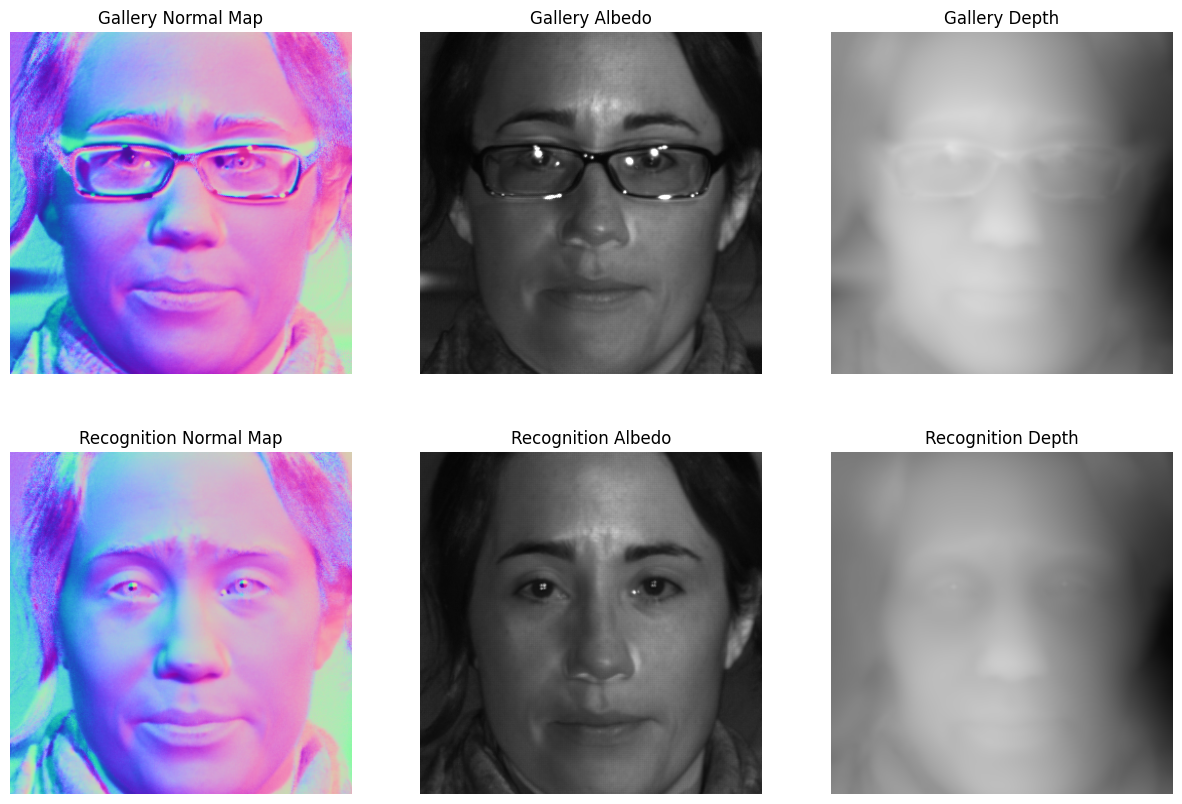

In [34]:
gallery_image_path = '1162/2009-11-27_14-52-18.exr'
gallery_normal = cv2.cvtColor(cv2.imread('./Dataset/Normal_Map/gallery/' + gallery_image_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
gallery_albedo = cv2.cvtColor(cv2.imread('./Dataset/Albedo/gallery/' + gallery_image_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_GRAY2RGB)
gallery_depth = cv2.cvtColor(cv2.imread('./Dataset/Depth_Map/gallery/' + gallery_image_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(gallery_normal)
plt.axis('off')
plt.title('Gallery Normal Map')

plt.subplot(2,3,2)
plt.imshow(gallery_albedo, cmap='gray')
plt.axis('off')
plt.title('Gallery Albedo')

plt.subplot(2,3,3)
plt.imshow(gallery_depth, cmap='gray')
plt.axis('off')
plt.title('Gallery Depth')

plt.subplot(2,3,4)
plt.imshow(normal)
plt.axis('off')
plt.title('Recognition Normal Map')

plt.subplot(2,3,5)
plt.imshow(albedo, cmap='gray')
plt.axis('off')
plt.title('Recognition Albedo')

plt.subplot(2,3,6)
plt.imshow(depth, cmap='gray')
plt.axis('off')
plt.title('Recognition Depth')

plt.show()